In [82]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
tfk=tf.keras
tfkl=tf.keras.layers
tfd=tfp.distributions
tfb=tfp.bijectors
tfl=tfp.layers
import matplotlib.pyplot as plt
import precession
import random
random.seed(5)
tf.random.set_seed(5)
import math
import scipy

import re
%matplotlib inline
import corner
import h5py

In [83]:
def make_bijector_kwargs(bijector, name_to_kwargs):
  if hasattr(bijector, 'bijectors'):
      return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
  else:
      for name_regex, kwargs in name_to_kwargs.items():
          if re.match(name_regex, bijector.name):
              return kwargs
  return {}


In [84]:
def nf_model(ndim):
    bijects=[]

    bs=[tfb.Chain([tfb.Scale(scale=.5), tfb.Shift(1.), tfb.Tanh()]),tfb.Chain([tfb.Scale(scale=np.pi/2),tfb.Shift(1.), tfb.Tanh()]), tfb.Chain([tfb.Scale(scale=np.pi), tfb.Shift(1.) , tfb.Tanh()])]
    blockwise=tfb.Blockwise(bs, block_sizes=[3,2,1])
    bijects.append(blockwise)
    
    l2=tf.keras.regularizers.l2(l2=0.01)
    
    # Density estimation with MADE.
    for i in range(10):
      made = tfb.AutoregressiveNetwork(
        params=2,
        hidden_units=[1024],
        event_shape=(ndim,),
        conditional=True,
        conditional_event_shape=(1,),
        #conditional_input_layers='first_layer',
        activation='leaky_relu',
        kernel_initializer='RandomNormal',
        bias_initializer='RandomNormal',
        kernel_regularizer=l2
        # bias_regularizer='L2'
      )
      masked_made=tfb.MaskedAutoregressiveFlow(made, name=f'maf{i}')
      bijects.append(masked_made)
      print(masked_made)

      permute=tfb.Permute(list(reversed(range(ndim))))
      bijects.append(permute)

    final_bijector=tfb.Chain(bijects)


    distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(0., 1.), sample_shape=[ndim]),
    bijector=final_bijector)
    
    # Construct and fit model.
    x_ = tfkl.Input(shape=(ndim,), dtype=tf.float32)
    c_ = tfkl.Input(shape=(1,), dtype=tf.float32)


    log_prob_ = distribution.log_prob(x_,
    bijector_kwargs=make_bijector_kwargs(distribution.bijector, {'maf.': {'conditional_input': c_}}))

    model = tfk.Model([x_, c_], log_prob_)
    
    return [model, final_bijector]

    
    
    

In [85]:
model, final_bijector=nf_model(ndim=6)


tfp.bijectors.MaskedAutoregressiveFlow("maf0", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf1", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf2", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf3", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf4", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf5", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf6", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf7", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf8", batch_shape=[], min_event_ndims=1)
tfp.bijectors.MaskedAutoregressiveFlow("maf9", batch_shape=[], min_event_ndims=1)


In [5]:
ndim=6
model.load_weights('maf5.hdf5')
distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(0., 1.), sample_shape=[ndim]),
    bijector=final_bijector)

(7886,)


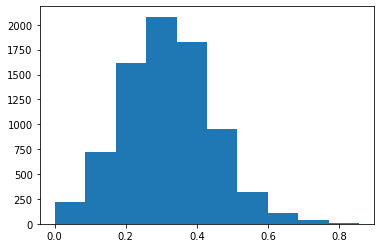

In [6]:
f = h5py.File('/data/mmould/lvc/GWTC-2.1_new/IGWN-GWTC2p1-v2-GW190412_053044_PEDataRelease_mixed_cosmo.h5', 'r')
f.keys()
f['C01:Mixed'].keys()
sorted(f['C01:Mixed']['posterior_samples'].dtype.names)
plt.hist(f['C01:Mixed']['posterior_samples']['a_1'])
print(f['C01:Mixed']['posterior_samples']['a_1'].shape)

In [55]:
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_1'],int(1e4), replace=True)
sampled_dist.mean()

0.31707393456768473

In [ ]:
col_samples=np.zeros((1,6))
for i in range(0,int(sampled_dist.shape[0])):
    samples = distribution.sample(
    int(1e3),
    bijector_kwargs=make_bijector_kwargs(
        distribution.bijector,
        {'maf.': {'conditional_input': np.array([sampled_dist[i]])}}),
        ).numpy()
    n_nan=np.isnan(samples).sum()//6
    
    samples_1, samples_r=np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32), np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32)
    for i in range(samples.shape[1]):
        samples_1=samples[np.isfinite(samples[:,i])][:,i].reshape(-1,1)
        samples_r=np.hstack([samples_r, samples_1])
        
    samples_r=samples_r[:,1:]
    
    col_samples=np.vstack((col_samples, samples_r))
    
    
col_samples=col_samples[1:,:]
col_samples
    
    
    
    
    

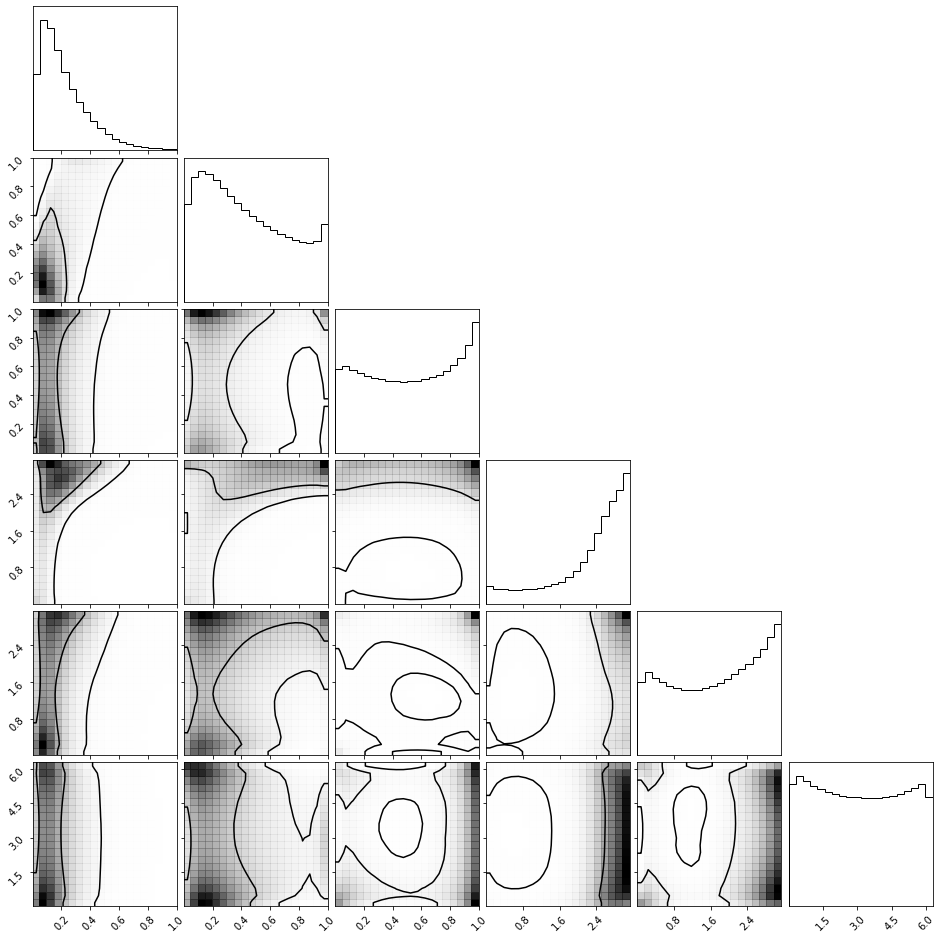

In [14]:
corner.corner(
    col_samples, plot_datapoints=False, plot_density=True,
    levels=[.5, .9], smooth=.5, label=['q,chi1,chi2,theta1,theta2,deltaphi']
    );


(7886,)


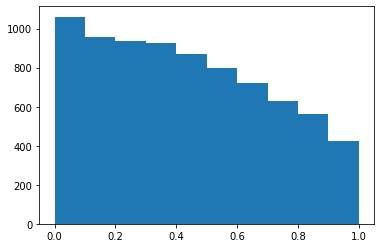

In [86]:
f = h5py.File('/data/mmould/lvc/GWTC-2.1_new/IGWN-GWTC2p1-v2-GW190412_053044_PEDataRelease_mixed_cosmo.h5', 'r')
f.keys()
f['C01:Mixed'].keys()
sorted(f['C01:Mixed']['posterior_samples'].dtype.names)
plt.hist(f['C01:Mixed']['posterior_samples']['a_2'])
print(f['C01:Mixed']['posterior_samples']['a_2'].shape)
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_2'],int(1e4))

In [88]:
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_2'],int(1e4))
sampled_dist.mean()

0.4333194742367172

In [ ]:
col_samples_1=np.zeros((1,6))
for i in range(0,int(sampled_dist.shape[0])):
    samples = distribution.sample(
    int(1e4),
    bijector_kwargs=make_bijector_kwargs(
        distribution.bijector,
        {'maf.': {'conditional_input': np.array([sampled_dist[i]])}}),
        ).numpy()
    n_nan=np.isnan(samples).sum()//6
    
    samples_1, samples_r=np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32), np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32)
    for i in range(0,samples.shape[1]):
        samples_1=samples[np.isfinite(samples[:,i])][:,i].reshape(-1,1)
        samples_r=np.hstack([samples_r, samples_1])
        
    samples_r=samples_r[:,1:]
    
    col_samples_1=np.vstack((col_samples_1, samples_r))
    
    
col_samples_1=col_samples_1[1:,:]
col_samples_1
    
    
    
    
    

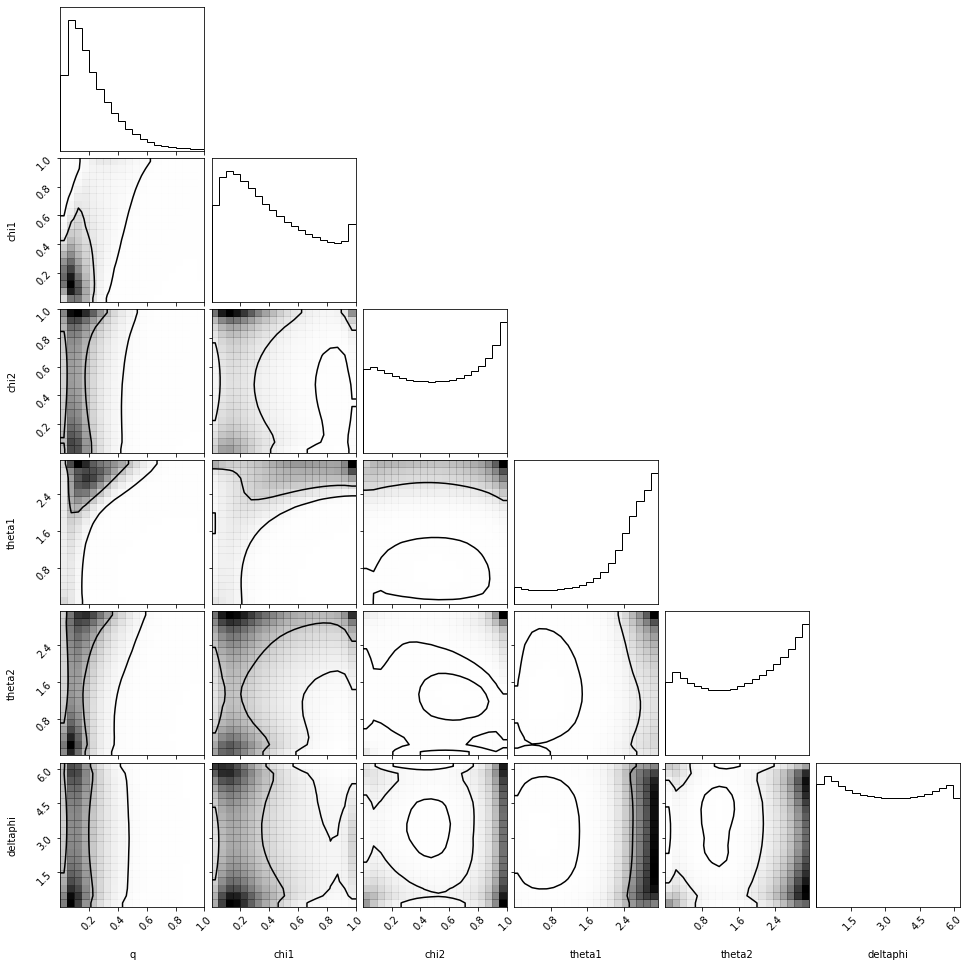

In [62]:
corner.corner(
    col_samples_1, plot_datapoints=False, plot_density=True,
    levels=[.5, .9], smooth=.5, labels=['q','chi1','chi2','theta1', 'theta2', 'deltaphi']
    );


In [27]:
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_1'],int(1e4), replace=True)

In [28]:
import statistics
statistics.median(sampled_dist)

0.3173251525032933

In [39]:
sampled_dist=np.random.choice(f['C01:Mixed']['posterior_samples']['a_2'],int(1e4), replace=True)

In [40]:
import statistics
statistics.median(sampled_dist)

0.4021844342601381

In [48]:
samples = distribution.sample(
    int(1e5),
    bijector_kwargs=make_bijector_kwargs(
        distribution.bijector,
        {'maf.': {'conditional_input': np.array([0.40])}}),
        ).numpy()

n_nan=np.isnan(samples).sum()//6
    
samples_1, samples_r=np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32), np.zeros((samples.shape[0]-n_nan,1),dtype=np.float32)
for i in range(samples.shape[1]):
    samples_1=samples[np.isfinite(samples[:,i])][:,i].reshape(-1,1)
    samples_r=np.hstack([samples_r, samples_1])

samples_r=samples_r[:,1:]


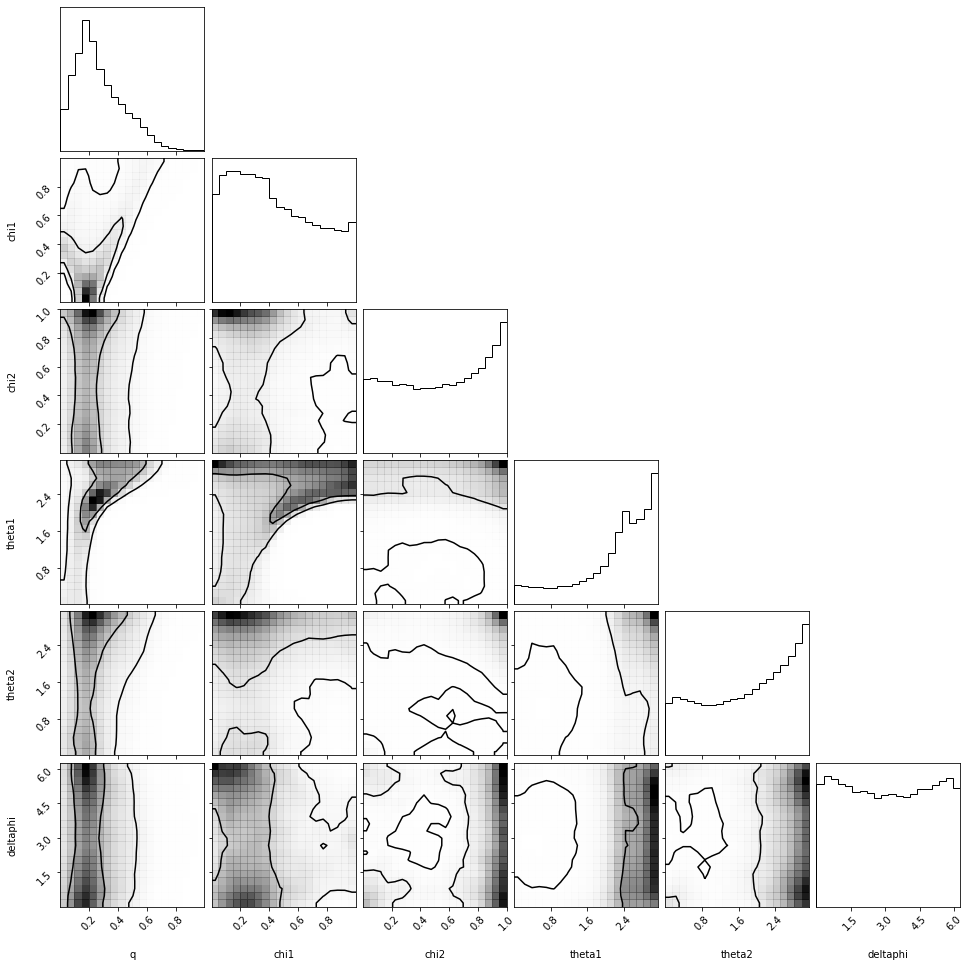

In [49]:
corner.corner(
    samples_r, plot_datapoints=False, plot_density=True,
    levels=[.5, .9], smooth=.8, labels=['q','chi1','chi2','theta1', 'theta2', 'deltaphi']
    );




In [50]:
col_samples

array([[0.14932066, 0.41295302, 0.173127  , 2.86002493, 0.90359038,
        3.13266778],
       [0.05858332, 0.30960059, 0.06410015, 2.89522481, 3.03098774,
        1.00953388],
       [0.07122773, 0.11123466, 0.6070202 , 2.80160642, 2.67542243,
        3.47587991],
       ...,
       [0.40621156, 0.48429164, 0.35646492, 2.90146637, 1.75062585,
        3.01631331],
       [0.19984958, 0.04239807, 0.86947685, 1.6987952 , 3.00743675,
        5.95407248],
       [0.45096278, 0.89712346, 0.75736737, 2.44667816, 2.5078485 ,
        3.67147422]])

In [51]:
col_samples_1

array([[0.05858332, 0.30960059, 0.06410015, 2.89522481, 3.03098774,
        1.00953388],
       [0.07122773, 0.11123466, 0.6070202 , 2.80160642, 2.67542243,
        3.47587991],
       [0.19862184, 0.60637879, 0.39810157, 2.92484474, 2.96292901,
        4.99433374],
       ...,
       [0.7619167 , 0.37813681, 0.13136047, 1.09401643, 1.65300798,
        2.573102  ],
       [0.75853622, 0.65023881, 0.10258946, 1.51990044, 0.77296203,
        2.84409475],
       [0.48848906, 0.253429  , 0.80186796, 0.89329123, 0.59289002,
        5.31672001]])

(7886,)


0.405735940535967

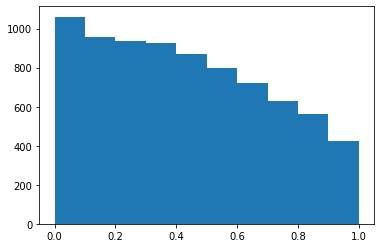

In [68]:
plt.hist(f['C01:Mixed']['posterior_samples']['a_2'])
print(f['C01:Mixed']['posterior_samples']['a_2'].shape)
statistics.median(f['C01:Mixed']['posterior_samples']['a_2'])

(7886,)


0.3147221567094267

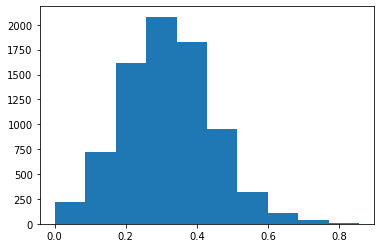

In [70]:
plt.hist(f['C01:Mixed']['posterior_samples']['a_1'])
print(f['C01:Mixed']['posterior_samples']['a_1'].shape)
statistics.median(f['C01:Mixed']['posterior_samples']['a_1'])

(array([1383., 1179., 1186., 1132., 1139., 1013.,  915.,  821.,  697.,
         535.]),
 array([1.10284436e-04, 9.99790726e-02, 1.99847861e-01, 2.99716649e-01,
        3.99585437e-01, 4.99454225e-01, 5.99323013e-01, 6.99191801e-01,
        7.99060589e-01, 8.98929378e-01, 9.98798166e-01]),
 <BarContainer object of 10 artists>)

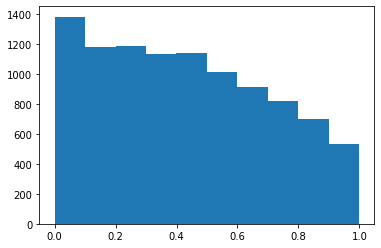

In [74]:
plt.hist(sampled_dist)